In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

from functools import partial

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from test import generate_dataset, shuffle_matrices
from online_dp import SliceDPModel, LinearModule, MLPModule
from sim_utils import generate_multi_mode_data, generate_label_matrix

import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Plotting the Simulations

In [2]:
def plot_error(rpca_errs, amc_errs, burg_errs, idx, iters, vals_list, vals_label, line_labels=['Reweighted', 'Normal', 'SystemX']):
    """
    Plot a line graph with 95% CI shaded!
    """

    #create pandas dataframe
    m_list = vals_list
    rpca_errs_dataframe = pd.DataFrame([obj[idx] for obj in rpca_errs])
    rpca_errs_dataframe['m'] = pd.Series(m_list*iters, index=rpca_errs_dataframe.index)
    
    amc_errs_dataframe = pd.DataFrame([obj[idx] for obj in amc_errs])
    amc_errs_dataframe['m'] = pd.Series(m_list*iters, index=amc_errs_dataframe.index)
    
    burg_errs_dataframe = pd.DataFrame([obj[idx] for obj in burg_errs])
    burg_errs_dataframe['m'] = pd.Series(m_list*iters, index=burg_errs_dataframe.index)



    #create plot
    sns.lineplot(x='m', y=0, data=rpca_errs_dataframe, marker=False, linestyle='dashdot', palette=sns.color_palette("GnBu_d",3), ci=50)
    sns.lineplot(x='m', y=0, data=amc_errs_dataframe, marker=False, linestyle='dashdot', palette = sns.color_palette("GnBu_d",3), ci=50)
    sns.lineplot(x='m', y=0, data=burg_errs_dataframe, marker=False, linestyle='dashdot', palette = sns.color_palette("GnBu_d",3), ci=50)
    
    if idx == 6:
        plt.ylabel("Accuracy")
        plt.title('Entire Dataset')
        plt.ylim([0.75,1.0])
    if idx == 2:
        plt.ylabel("Accuracy")
        plt.title('Head Slice')
        plt.ylim([0.0,1.0])
    if idx == 5:
        plt.ylabel("Accuracy")
        plt.title('Head-Torso Overlap')
        plt.ylim([0.0,1.0])

    plt.xlabel(vals_label)
    plt.legend(line_labels)
    
    sns.despine()
    plt.tight_layout()

**Add Model 1 Lines as "reweighted" and the current reweighted as "SystemX"** 

**Writing**
whackamole problem, the popular thing to do is the one that's not that great on this "head" slice. everything is a head slice. yellow lights example from Andrej Karpathy. 

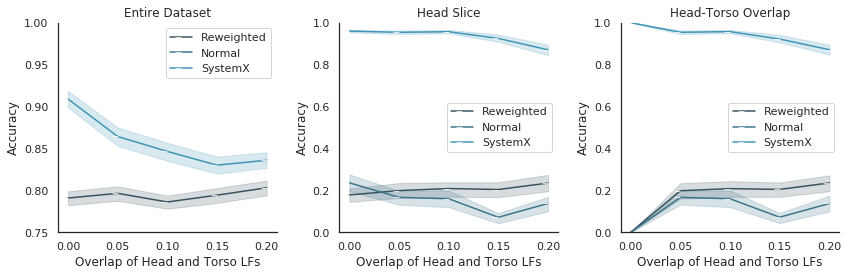

In [3]:
import pandas as pd
import seaborn as sns

model_0_scores = np.load('op2_model_0_scores.npy')
model_1_scores = np.load('op2_model_1_scores.npy')
model_2_scores = np.load('op2_model_2_scores.npy')

#i coded the simulation wrong 
model_2_scores_adj = np.copy(model_2_scores)
model_2_scores_adj[np.where(np.isnan(model_2_scores))] = 1.
model_2_scores_adj[np.where(model_2_scores == 0.)] = 1.


vals_list = [0.0, 0.05, 0.1, 0.15, 0.2]
vals_label = "Overlap of Head and Torso LFs"

iters = int(np.shape(model_0_scores)[0]/float(len(vals_list)))

sns.set_context('notebook')
sns.set_style('white')
sns.set_palette(sns.color_palette("GnBu_d"))


plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plot_error(model_0_scores, model_1_scores, model_2_scores_adj, 6, iters, vals_list, vals_label)

plt.subplot(1,3,2)
plot_error(model_0_scores, model_1_scores, model_2_scores_adj, 2, iters, vals_list, vals_label)

plt.subplot(1,3,3)
plot_error(model_0_scores, model_1_scores, model_2_scores_adj, 5, iters, vals_list, vals_label)

plt.savefig('')

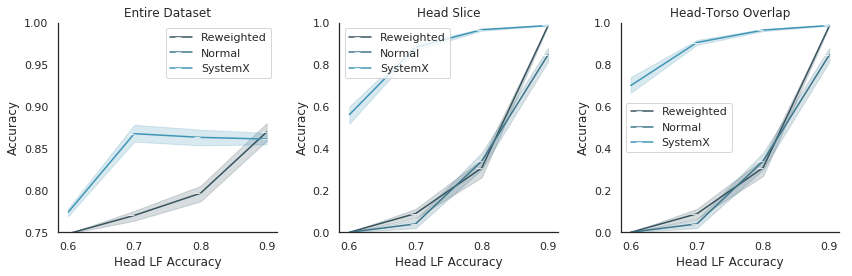

In [4]:
import pandas as pd
import seaborn as sns

model_0_scores = np.load('ha_model_0_scores.npy')
model_1_scores = np.load('ha_model_1_scores.npy')
model_2_scores = np.load('ha_model_2_scores.npy')

model_2_scores_adj = np.copy(model_2_scores)
model_2_scores_adj[np.where(np.isnan(model_2_scores))] = 1.

model_0_scores_adj = np.copy(model_0_scores)
model_0_scores_adj[np.where(model_0_scores <= 0.5)] = 1.45-model_0_scores_adj[np.where(model_0_scores <= 0.5)]

#i coded the simulation wrong 
model_2_scores_adj[np.where(model_2_scores == 0.)] = 1.
model_2_scores_adj[np.where(np.isnan(model_2_scores))] = 1.


vals_list = [0.6, 0.7, 0.8, 0.9]
vals_label = "Head LF Accuracy"

iters = int(np.shape(model_0_scores)[0]/float(len(vals_list)))

sns.set_context('notebook')
sns.set_style('white')
sns.set_palette(sns.color_palette("GnBu_d"))


plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plot_error(model_0_scores_adj, model_1_scores, model_2_scores_adj, 6, iters, vals_list, vals_label)

plt.subplot(1,3,2)
plot_error(model_0_scores, model_1_scores, model_2_scores_adj, 2, iters, vals_list, vals_label)

plt.subplot(1,3,3)
plot_error(model_0_scores, model_1_scores, model_2_scores_adj, 5, iters, vals_list, vals_label)